In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from change_of_parameters import omega_CDM_to_luisa
from constants import OMEGA_R_0

sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
#path_git = git.Repo('.', search_parent_directories=True).working_tree_dir


from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
import numpy as np

from matplotlib import pyplot as plt
from scipy.linalg import sqrtm

from seaborn import heatmap
import pandas as pd
import emcee


def F_H(H, params, model):     
    lamb, L, beta, L_bar = params
    if model == 'GILA':
        FH = H**2 \
           + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2) \
           - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10)
    
    elif model == 'BETA':
        FH = H**2 \
            + H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4) \
            - H**2        * beta * np.exp(-beta*(L_bar*H)**8) 

    return FH

In [18]:
discard=0
thin=1
root_dic = '/home/matias/Documents/Repos/GILA-output/paper/'
root_dic = '/home/mleize/Documents/Repos/GILA-output/paper/'

# Get the samples:
samples_lcdm = emcee.backends.HDFBackend(root_dic + 'sample_LCDM_PPS_CC_DESI_4params/sample_LCDM_PPS_CC_DESI_4params.h5')
#samples_beta = emcee.backends.HDFBackend(root_dic + 'sample_BETA_PPS_CC_DESI_4params/sample_BETA_PPS_CC_DESI_4params.h5')
#samples_gila = emcee.backends.HDFBackend(root_dic + 'sample_GILA_PPS_CC_DESI_4params/sample_GILA_PPS_CC_DESI_4params.h5')
#samples_lcdm = emcee.backends.HDFBackend(root_dic + 'sample_LCDM_PPS_CC_DESI_3params/sample_LCDM_PPS_CC_DESI_4params.h5')
samples_beta = emcee.backends.HDFBackend(root_dic + 'sample_BETA_PPS_CC_DESI_4params/sample_BETA_PPS_CC_DESI_4params.h5')
samples_gila = emcee.backends.HDFBackend(root_dic + 'sample_GILA_PPS_CC_DESI_4params/sample_GILA_PPS_CC_DESI_4params.h5')



#nwalkers, ndim = reader_lcdm.shape #Number of walkers and parameters
flat_samples_lcdm = samples_lcdm.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_beta = samples_beta.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila = samples_gila.get_chain(discard=discard, flat=True, thin=thin)

L_bar = 0.90
names_LCDM = ['M_{{abs}}','H_0','\omega_m','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_LCDM = names_LCDM
names_GILA = ['M_{{abs}}','\\beta','H_0','\omega_m','\Omega_{{m}}^{{GILA-\\beta}}','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_GILA = names_GILA

names_GILA_1 = ['\\beta','H_0','\omega_m','\Omega_{{m}}^{{GILA-\\beta}}']
names_GILA_2 = ['\omega_m','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']

In [19]:
flat_samples_lcdm

array([[-1.93564980e+01,  1.45759250e+02,  1.41800282e-01,
         6.93960495e+01],
       [-1.94512319e+01,  1.45406809e+02,  1.44619149e-01,
         7.04410816e+01],
       [-1.94025242e+01,  1.46295702e+02,  1.45836374e-01,
         6.97220813e+01],
       ...,
       [-1.92958114e+01,  1.40207739e+02,  1.57319386e-01,
         7.22002619e+01],
       [-1.93524995e+01,  1.41973498e+02,  1.56140669e-01,
         7.02003226e+01],
       [-1.93254973e+01,  1.41827760e+02,  1.56995666e-01,
         7.11303745e+01]])

LCDM rd:139.88404350202205
BETA rd:141.29267221367812
GILA rd:140.79570880551307


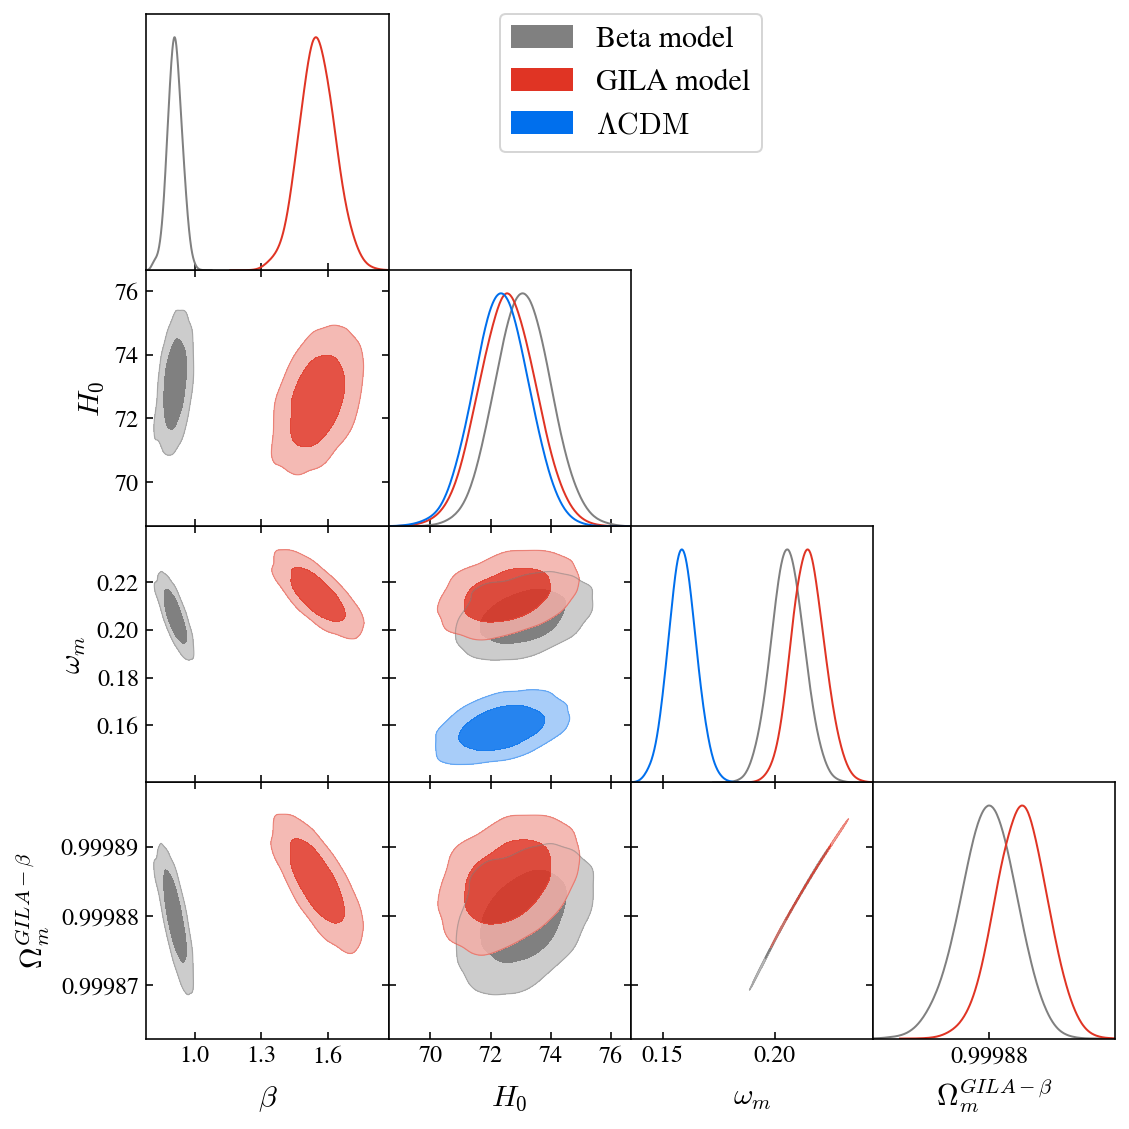

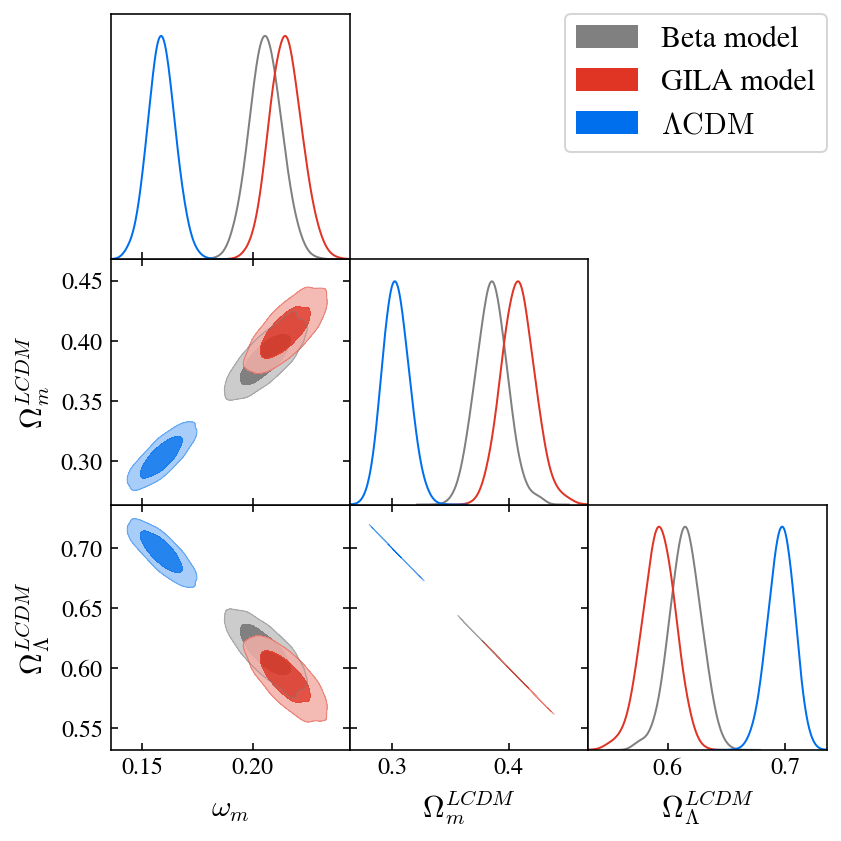

In [27]:
#LCDM MODEL
M_abs = flat_samples_lcdm[:,0]
rd = flat_samples_lcdm[:,1] 
omega_m = flat_samples_lcdm[:,2]
H0 = flat_samples_lcdm[:,3]
print('LCDM rd:{}'.format(np.mean(rd)))
Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_lcdm = np.zeros((len(M_abs),5))
chains_lcdm[:,0] = M_abs
chains_lcdm[:,1] = H0
chains_lcdm[:,2] = omega_m
chains_lcdm[:,3] = Omega_m_lcdm
chains_lcdm[:,4] = Omega_L_lcdm

#BETA MODEL
M_abs = flat_samples_beta[:,0]
rd = flat_samples_beta[:,1]
beta = flat_samples_beta[:,2]
H0 = flat_samples_beta[:,3]
print('BETA rd:{}'.format(np.mean(rd)))

omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'BETA')/(100**2) - OMEGA_R_0

Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'BETA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'BETA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_beta = np.zeros((len(M_abs),7))
chains_beta[:,0] = M_abs
chains_beta[:,1] = beta
chains_beta[:,2] = H0
chains_beta[:,3] = omega_m
chains_beta[:,4] = Omega_m_gila
chains_beta[:,5] = Omega_m_lcdm
chains_beta[:,6] = Omega_L_lcdm

#GILA MODEL

M_abs = flat_samples_gila[:,0]
rd = flat_samples_gila[:,1]
beta = flat_samples_gila[:,2]
H0 = flat_samples_gila[:,3]
print('GILA rd:{}'.format(np.mean(rd)))


omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'GILA')/(100**2) - OMEGA_R_0
Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'GILA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'GILA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_gila = np.zeros((len(M_abs),7))
chains_gila[:,0] = M_abs
chains_gila[:,1] = beta
chains_gila[:,2] = H0
chains_gila[:,3] = omega_m
chains_gila[:,4] = Omega_m_gila
chains_gila[:,5] = Omega_m_lcdm
chains_gila[:,6] = Omega_L_lcdm


samples1 = MCSamples(samples=chains_beta, names=names_GILA, labels=names_GILA)
samples1 = samples1.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples2 = MCSamples(samples=chains_gila, names=names_GILA, labels=names_GILA)
samples2 = samples2.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples3 = MCSamples(samples=chains_lcdm, names=names_LCDM, labels=names_LCDM)
samples3 = samples3.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})


g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples1, samples2, samples3],
				filled=True, params=names_GILA_1,
				#contour_colors=color,
				contour_lws=1,
				legend_labels=['Beta model','GILA model',r'$\Lambda \rm{{CDM}}$'])
g.export(root_dic + 'triangle_plot_beta_gila_lcdm_1_{}.pdf'.format(L_bar))


g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples1, samples2, samples3],
				filled=True, params=names_GILA_2,
				#contour_colors=color,
				contour_lws=1,
				legend_labels=['Beta model','GILA model',r'$\Lambda \rm{{CDM}}$'])
g.export(root_dic + 'triangle_plot_beta_gila_lcdm_2_{}.pdf'.format(L_bar))

In [22]:
def report_intervals(sampler, labels, discard=0, thin=1):
    if isinstance(sampler, np.ndarray)==True: #Posprocessed chains
        samples = sampler
        len_chain, ndim=samples.shape
    else:
        samples = sampler.get_chain(discard=discard, flat=True, thin=thin)
        len_chain, nwalkers, ndim = sampler.get_chain().shape

    #textfile_witness = open(save_path + '/intervals.dat','w')
    labels = labels
    for i in range(ndim):
        mean = np.mean(samples[:,i])
        one_s = 68
        two_s = 95

        one_sigma = az.hdi(samples,hdi_prob = one_s/100)[i]
        two_sigma = az.hdi(samples,hdi_prob = two_s/100)[i]

        q1 = np.diff([one_sigma[0],mean,one_sigma[1]])
        q2 = np.diff([two_sigma[0],mean,two_sigma[1]])

        if np.abs(one_sigma[0]) < 10**(-2): #Upper limit interval
            txt = "\mathrm{{{0}}} < {1:.3f}({2:.3f})"
            txt = txt.format(labels[i], mean + q1[1], mean + q2[1])

        else:
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}({4:.3f})}}^{{+{2:.3f}({5:.3f})}}"
            txt = txt.format(mean, q1[0], q1[1], labels[i], q2[0], q2[1])
        #textfile_witness.write('{} \n'.format(txt))
        print(txt)

In [23]:
from IPython.display import display, Math
import arviz as az
from scipy.stats import scoreatpercentile
from getdist import plots, MCSamples

#LCDM intervals
print('LCDM model intervals:')
report_intervals(chains_lcdm, names_LCDM)
print('\n')

#BETA intervals
print('Beta model intervals:')
report_intervals(chains_beta, names_GILA)
print('\n')

#GILA intervals
print('GILA model intervals:')
report_intervals(chains_gila, names_GILA)


LCDM model intervals:
\mathrm{M_{{abs}}} = -19.288_{-0.025(0.050)}^{+0.026(0.052)}
\mathrm{H_0} = 72.351_{-0.840(1.731)}^{+0.932(1.768)}
\mathrm{\omega_m} = 0.159_{-0.006(0.012)}^{+0.006(0.012)}
\mathrm{\Omega_{{m}}^{{LCDM}}} = 0.303_{-0.012(0.021)}^{+0.010(0.022)}


/home/mleize/miniconda3/envs/fR-MCMC/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


\mathrm{\Omega_{{\Lambda}}^{{LCDM}}} = 0.697_{-0.010(0.022)}^{+0.012(0.021)}


Beta model intervals:
\mathrm{M_{{abs}}} = -19.288_{-0.024(0.050)}^{+0.026(0.049)}
\mathrm{\beta} = 0.910_{-0.033(0.065)}^{+0.032(0.066)}
\mathrm{H_0} = 73.078_{-0.864(1.725)}^{+0.915(1.797)}
\mathrm{\omega_m} = 0.206_{-0.007(0.014)}^{+0.007(0.014)}
\mathrm{\Omega_{{m}}^{{GILA-\beta}}} = 1.000_{-0.000(0.000)}^{+0.000(0.000)}
\mathrm{\Omega_{{m}}^{{LCDM}}} = 0.385_{-0.014(0.027)}^{+0.012(0.026)}
\mathrm{\Omega_{{\Lambda}}^{{LCDM}}} = 0.615_{-0.012(0.026)}^{+0.014(0.027)}


GILA model intervals:
\mathrm{M_{{abs}}} = -19.293_{-0.025(0.051)}^{+0.026(0.049)}
\mathrm{\beta} = 1.551_{-0.081(0.149)}^{+0.077(0.170)}
\mathrm{H_0} = 72.559_{-0.950(1.793)}^{+0.890(1.838)}
\mathrm{\omega_m} = 0.215_{-0.008(0.014)}^{+0.007(0.015)}
\mathrm{\Omega_{{m}}^{{GILA-\beta}}} = 1.000_{-0.000(0.000)}^{+0.000(0.000)}
\mathrm{\Omega_{{m}}^{{LCDM}}} = 0.408_{-0.014(0.028)}^{+0.013(0.028)}
\mathrm{\Omega_{{\Lambda}}^{{LCDM}}} = 0.592_{

/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


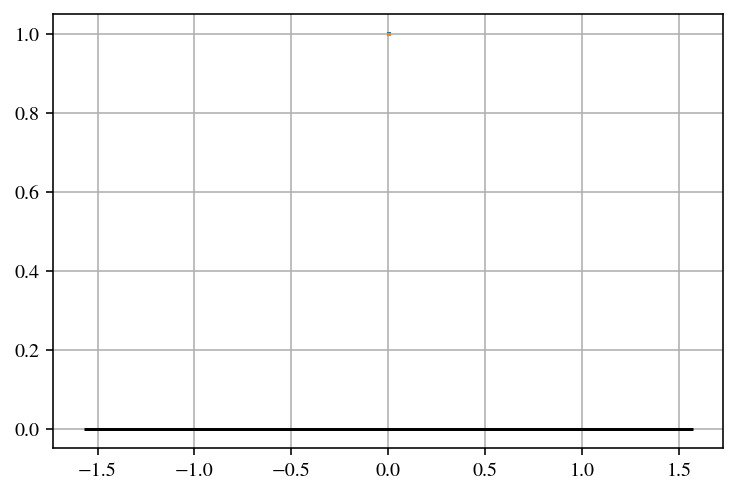

In [62]:
a = 0.8
#a = 0.99
#a = 1
#a= 1.1
a = 0.002
#a = 15

import numpy as np 
from matplotlib import pyplot as plt
phis = np.linspace(-np.pi/2,np.pi/2,1000)

plt.plot(phis, np.cos(phis)+np.sqrt(a**2  - np.sin(phis)**2))
plt.plot(phis, np.cos(phis)-np.sqrt(a**2  - np.sin(phis)**2))
plt.hlines(0,np.min(phis),np.max(phis))
plt.grid()